# Implementação de Estimação de Fase
Implementação do algoritmo usando $QFT^{-1}$ para estimar o ângulo do autovalor de $\left|\ 1 \right\rangle$ em relação ao $Z^{1/8}$ para executar no IBM Q 5 Tenerife

In [58]:
# Import the Qiskit SDK
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer

pi = 3.14159265359

In [64]:
def cRotation(qc, q, i, j, angle):
    
    half_a = angle / 2
    if i != 2 and j != 2:
        swap(qc, q, 2, j)
        cRotation(qc, q, i, 2, angle)
        swap(qc, q, 2, j)
    else:
        qc.u1(half_a, q[i])
        qc.cx(q[j], q[i])
        qc.u1(-half_a, q[i])
        qc.cx(q[j], q[i])
        qc.u1(half_a, q[j])
    
def swap(qc, q, i, j):
    if i != 2 and j != 2:
        swap(qc, q, 2, j)
        swap(qc, q, i, 2)
        swap(qc, q, 2, j)
    else:
        qc.cx(q[i], q[j])
        qc.cx(q[j], q[i])
        qc.cx(q[i], q[j])
    
def inverse_qft(qc, q, indices):
        
    rev = list(reversed(indices))
    
    
    #swaps need to happen
    N = len(rev)
    
    for i in  range(int(N / 2)):
        j = N - i - 1
        swap(qc, q, i, j)
    
    for n, i in enumerate(rev):
        
        angle = -pi/2**n
        
        for j in rev[:n]:
            
            cRotation(qc, q, i, j, angle)
            angle *= 2
    
        qc.h(q[i])

In [65]:
# Create a Quantum Register with 5 qubits.
q = QuantumRegister(5)
# Create a Classical Register with 5 bits for storing results.
c = ClassicalRegister(5)
# Create a Quantum Circuit
qc = QuantumCircuit(q, c)

# Add a H gate on 4 qubits, putting the qubits in superposition.

qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])

#Put qubit to |1>
qc.x(q[4])

cRotation(qc, q, 3, 4, pi/8)

cRotation(qc, q, 2, 4, pi/4)

cRotation(qc, q, 1, 4, pi/2)

cRotation(qc, q, 0, 4, pi)

inverse_qft(qc, q, range(4))


qc.measure(q, c)

In [66]:
# See a list of available local simulators# See a  
print("Local backends: ", available_backends({'local': True}))

# Compile and run the Quantum circuit on a simulator backend
job_sim = execute(qc, "local_qasm_simulator")
sim_result = job_sim.result()

# Show the results
print("simulation: ", sim_result)
print(sim_result.get_counts(qc))

Local backends:  ['local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']
simulation:  COMPLETED
{'11000': 1024}


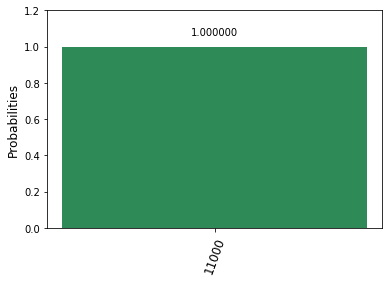

In [68]:
plot_histogram(sim_result.get_counts(qc))

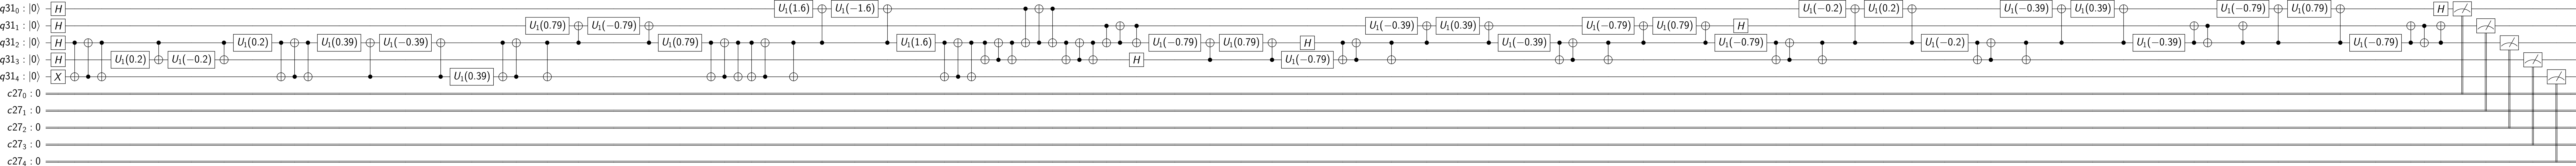

In [69]:
circuit_drawer(qc)

In [71]:
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q31[5];
creg c27[5];
h q31[0];
h q31[1];
h q31[2];
h q31[3];
x q31[4];
cx q31[2],q31[4];
cx q31[4],q31[2];
cx q31[2],q31[4];
u1(0.196349540849375) q31[3];
cx q31[2],q31[3];
u1(-0.196349540849375) q31[3];
cx q31[2],q31[3];
u1(0.196349540849375) q31[2];
cx q31[2],q31[4];
cx q31[4],q31[2];
cx q31[2],q31[4];
u1(0.392699081698750) q31[2];
cx q31[4],q31[2];
u1(-0.392699081698750) q31[2];
cx q31[4],q31[2];
u1(0.392699081698750) q31[4];
cx q31[2],q31[4];
cx q31[4],q31[2];
cx q31[2],q31[4];
u1(0.785398163397500) q31[1];
cx q31[2],q31[1];
u1(-0.785398163397500) q31[1];
cx q31[2],q31[1];
u1(0.785398163397500) q31[2];
cx q31[2],q31[4];
cx q31[4],q31[2];
cx q31[2],q31[4];
cx q31[2],q31[4];
cx q31[4],q31[2];
cx q31[2],q31[4];
u1(1.57079632679500) q31[0];
cx q31[2],q31[0];
u1(-1.57079632679500) q31[0];
cx q31[2],q31[0];
u1(1.57079632679500) q31[2];
cx q31[2],q31[4];
cx q31[4],q31[2];
cx q31[2],q31[4];
cx q31[2],q31[3];
cx q31[3],q31[2];
cx q31[2],q31[3];
cx q3